In [1]:
import os, sys, time
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import warnings
warnings.filterwarnings('ignore')
from multihist import Histdd, Hist1d
from tqdm import tqdm
from contextlib import contextmanager

def plt_config(title=None, xlim=None, ylim=None, xlabel=None, ylabel=None, colorbar=False, sci=False, art=plt):
    for field in ['title', 'xlim', 'ylim', 'xlabel', 'ylabel']:
        if eval(field) != None: getattr(art, field)(eval(field))
    if isinstance(sci, str): art.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
    if isinstance(colorbar,str): art.colorbar(label=colorbar)
    elif colorbar: art.colorbar(label = '$Number\ of\ Entries$')

@contextmanager
def initiate_plot(dimx=24, dimy=9):
    plt.rcParams['figure.figsize'] = (dimx, dimy)
    global fig; fig = plt.figure()
    yield
    plt.show()

In [2]:
from numba import vectorize, guvectorize, int64, int32, float64
@vectorize([float64(float64, float64, float64, float64)])
def func_nb(a1, a2, b1, b2):
    # Calculate the overlap between two segments on an axis
    return min(a2, b2) - max(a1, b1)

In [3]:
# Heavy lifting part of this nb

def simulations(model_random_gen, total_time=1000, tao=0.1, ratio=100):
    n_s2 = total_time * 5 # Let's say there are 5 S2s per second (like in background runs)
    t_s2 = np.random.uniform(0, total_time, n_s2) # And for each of them give it time
    t_s2.sort() # Sort them in order, necessary for the 'digitize' step
    
    n_ele = ratio * n_s2 # Now let's say on average every S2 generate (1*ratio) of electrons
    dt_model = model_random_gen(n_ele) # Their time delay from their parent S2 follow this exponential model
    t_ele = dt_model + np.random.choice(t_s2, replace=True, size=n_ele) # Now randomly add those to the S2 times to get s-electron times
    del dt_model
    
    # Here is a trick (digitize) to find for each single-e, which 2 S2s that it's located in between
    s2_s2_slot = np.digitize(t_ele, t_s2) 
    t_s2_associate_pre = t_s2[s2_s2_slot-1] # The S2s right before each single-e
    t_s2_associate_pos = np.hstack([t_s2, np.inf])[s2_s2_slot] # The S2s right after each single-e
    
    dt_associate_pre = t_ele - t_s2_associate_pre # Time delay of each single-e from the S2 before it
    dt_associate_pos = t_s2_associate_pos - t_ele # Time delay of the S2 after it from each single-e
    del s2_s2_slot, t_s2_associate_pre, t_s2_associate_pos
    
    
    # Start to filling histograms
    #### 1 Amanda's triggerless cases, all single electrons should be related it's prvious S2
    ph_dt_0 = Hist1d(dt_associate_pre, bins=bins)
    ph_lt_0 = Hist1d(np.diff(t_s2, n=1), bins=np.linspace(0, 5, int(5/(bins[1]-bins[0]))+1)) # This is the pdf of time difference between 2 S2s
    # The actual live time should be cumulate from right hand side of this pdf
    ph_lt_0 = Hist1d.from_histogram(np.cumsum(ph_lt_0[::-1])[::-1][:len(bins)-1]*(bins[1]-bins[0]), bin_edges=ph_dt_0.bin_edges)

    
    #### 2 Tianyu's single pre-s1 (s2 in mc case) window
    # Now only those single-e right before 1ms of any S2s are taken
    ph_dt_1 = Hist1d(dt_associate_pre[dt_associate_pos<1e-3], bins=bins)
    
    Bleft = np.asarray(bins[:-1]); # left of bin edges
    Bright = np.asarray(bins[1:]); # right of bin edges
    Wleft = np.clip(t_s2[1:] - t_s2[:-1] - 1e-3, 0, np.inf); # left of all pre s1 window
    Wright = t_s2[1:] - t_s2[:-1]; # right of all pre s1 window
    
    # Some manipulation to histogram those pre s1 windows
    Bleft_grid, Wleft_grid = np.meshgrid(Bleft, Wleft, sparse=False, indexing='ij')
    Bright_grid, Wright_grid = np.meshgrid(Bright, Wright, sparse=False, indexing='ij')

    D2lt = func_nb(Bleft_grid.reshape((-1,)), Bright_grid.reshape((-1,)), 
                   Wleft_grid.reshape((-1,)), Wright_grid.reshape((-1,)))
    D2lt = D2lt.reshape((Bleft.shape[0], Wleft.shape[0]))
    D2lt[D2lt < 0] = 0
    
    live_time_hist = np.sum(D2lt, axis=1)
    
    ph_lt_1 = Hist1d.from_histogram(live_time_hist, bin_edges=ph_lt_0.bin_edges)
    del Wleft, Wright, Bleft_grid, Wleft_grid, Bright_grid, Wright_grid, D2lt

    
    #### 3 Jaques's multiple pre-s1 windows
    # Now it's a bit more complicated
    # those single-e right before 1ms of any S2s
    # AND 2ms after previous S2 are taken
    ele_mask = (dt_associate_pos < 1e-3) & (dt_associate_pre > 2e-3)
    
    # Each electron is repreatedly compared to all the S2 peaks, (we do the selection in next step)
    t_ele_tile = np.tile(t_ele[ele_mask], len(t_s2)).reshape(len(t_s2), len(t_ele[ele_mask]))
    t_s2_repeat = np.repeat(t_s2, len(t_ele[ele_mask])).reshape(len(t_s2), len(t_ele[ele_mask]))
    dt_associate_all = t_ele_tile - t_s2_repeat
    
    # Remove those cases single-e is before that associated S2
    # Remove thsoe cases single-e is 1s after that associated S2
    dt_associate_all = dt_associate_all[(dt_associate_all>0) & (dt_associate_all<1)]
    ph_dt_2 = Hist1d(dt_associate_all, bins=bins)
    del ele_mask, t_ele_tile, t_s2_repeat, dt_associate_all
    
    # Now calculating live time is even more complicated, 
    # We also need to increase the dimensionality to do the calculation
    
    # Need to get the LEFT of each pre-s1 window delay from any other S2 peaks
    # Also need to get the RIGHT of each pre-s1 window delay from any other S2 peaks
    # But in our simulation, LEFT and RIGHT can be derived from time of every S2s from any S2s
    t_s2_repeat = np.tile(t_s2, len(t_s2)).reshape(len(t_s2), len(t_s2))
    Wleft = t_s2_repeat - t_s2_repeat.T - 1e-3 # Ommit B1[B1<0] = 0 as we will require B1>2e-3
    Wright = t_s2_repeat - t_s2_repeat.T
    
    s2_mask = (Wleft > 2e-3) & (Wright < 1)
    Wleft = Wleft[s2_mask]; Wright = Wright[s2_mask]
    
    # Again, some manipulation to histogram those pre s1 windows
    Bleft_grid, Wleft_grid = np.meshgrid(Bleft, Wleft, sparse=False, indexing='ij')
    Bright_grid, Wright_grid = np.meshgrid(Bright, Wright, sparse=False, indexing='ij')

    D2lt = func_nb(Bleft_grid.reshape((-1,)), Bright_grid.reshape((-1,)), 
                   Wleft_grid.reshape((-1,)), Wright_grid.reshape((-1,)))
    D2lt = D2lt.reshape((Bleft.shape[0], Wleft.shape[0]))
    D2lt[D2lt < 0] = 0
    
    live_time_hist = np.sum(D2lt, axis=1)

    ph_lt_2 = Hist1d.from_histogram(np.sum(D2lt, axis=1), bin_edges=ph_lt_0.bin_edges)
    del Bleft, Bright, Wleft, Wright, Bleft_grid, Wleft_grid, Bright_grid, Wright_grid, D2lt
    
    return (ph_dt_0, ph_lt_0, ph_dt_1, ph_lt_1, ph_dt_2, ph_lt_2)

In [5]:
bins = np.linspace(0, 1, 101);
total_time = 1000; # simulated time span
tao = 0.1; # electron train decay constant
ratio = 50; # number of model electron train per s2
histograms = np.zeros((6, len(bins)-1))


def exponential_model_random_gen(n):
    return np.random.exponential(tao, n)

n_loop = 18 # 18*1000s ~ 5hr, need to break it down to 18 piecec due to RAM requirement
with tqdm(total = n_loop) as pBar:
    for ix in range(n_loop):
        pBar.update(1)
        histograms += simulations(exponential_model_random_gen, total_time, tao, ratio)

100%|██████████| 18/18 [00:23<00:00,  1.38s/it]


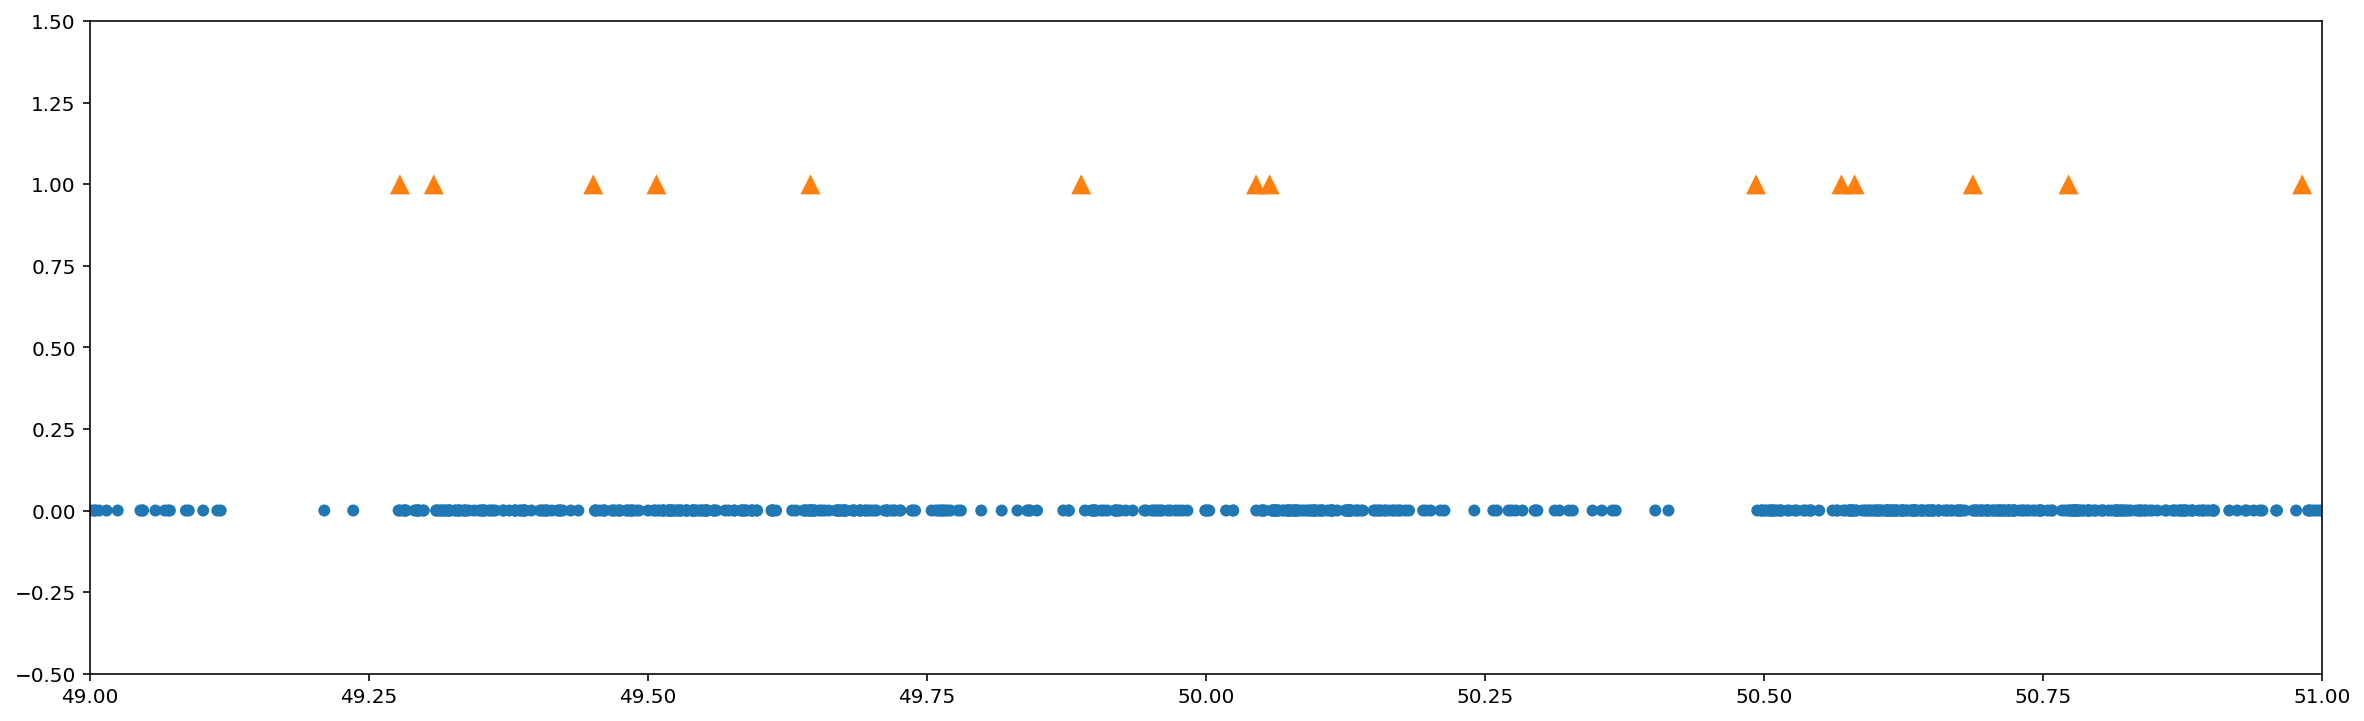

In [6]:
total_time = 100;
n_s2 = total_time * 5 # Let's say there are 5 S2s per second (like in background runs)
t_s2 = np.random.uniform(0, total_time, n_s2) # And for each of them give it time
t_s2.sort() # Sort them in order, necessary for the 'digitize' step

n_ele = ratio * n_s2 # Now let's say on average every S2 generate (1*ratio) of electrons
dt_model = exponential_model_random_gen(n_ele) # Their time delay from their parent S2 follow this exponential model
t_ele = dt_model + np.random.choice(t_s2, n_ele)

with initiate_plot(20, 6):
    plt.scatter(t_s2, np.ones_like(t_s2), color='C1', edgecolor='none', marker='^', s=100)
    plt.scatter(t_ele, np.zeros_like(t_ele), color='C0', edgecolor='none', )
    plt_config(xlim=[49, 51], ylim=[-0.5, 1.5])

In [7]:
ph_dt_0 = Hist1d.from_histogram(histograms[0], bin_edges = bins)
ph_lt_0 = Hist1d.from_histogram(histograms[1], bin_edges = bins)
ph_dt_1 = Hist1d.from_histogram(histograms[2], bin_edges = bins)
ph_lt_1 = Hist1d.from_histogram(histograms[3], bin_edges = bins)
ph_dt_2 = Hist1d.from_histogram(histograms[4], bin_edges = bins)
ph_lt_2 = Hist1d.from_histogram(histograms[5], bin_edges = bins)

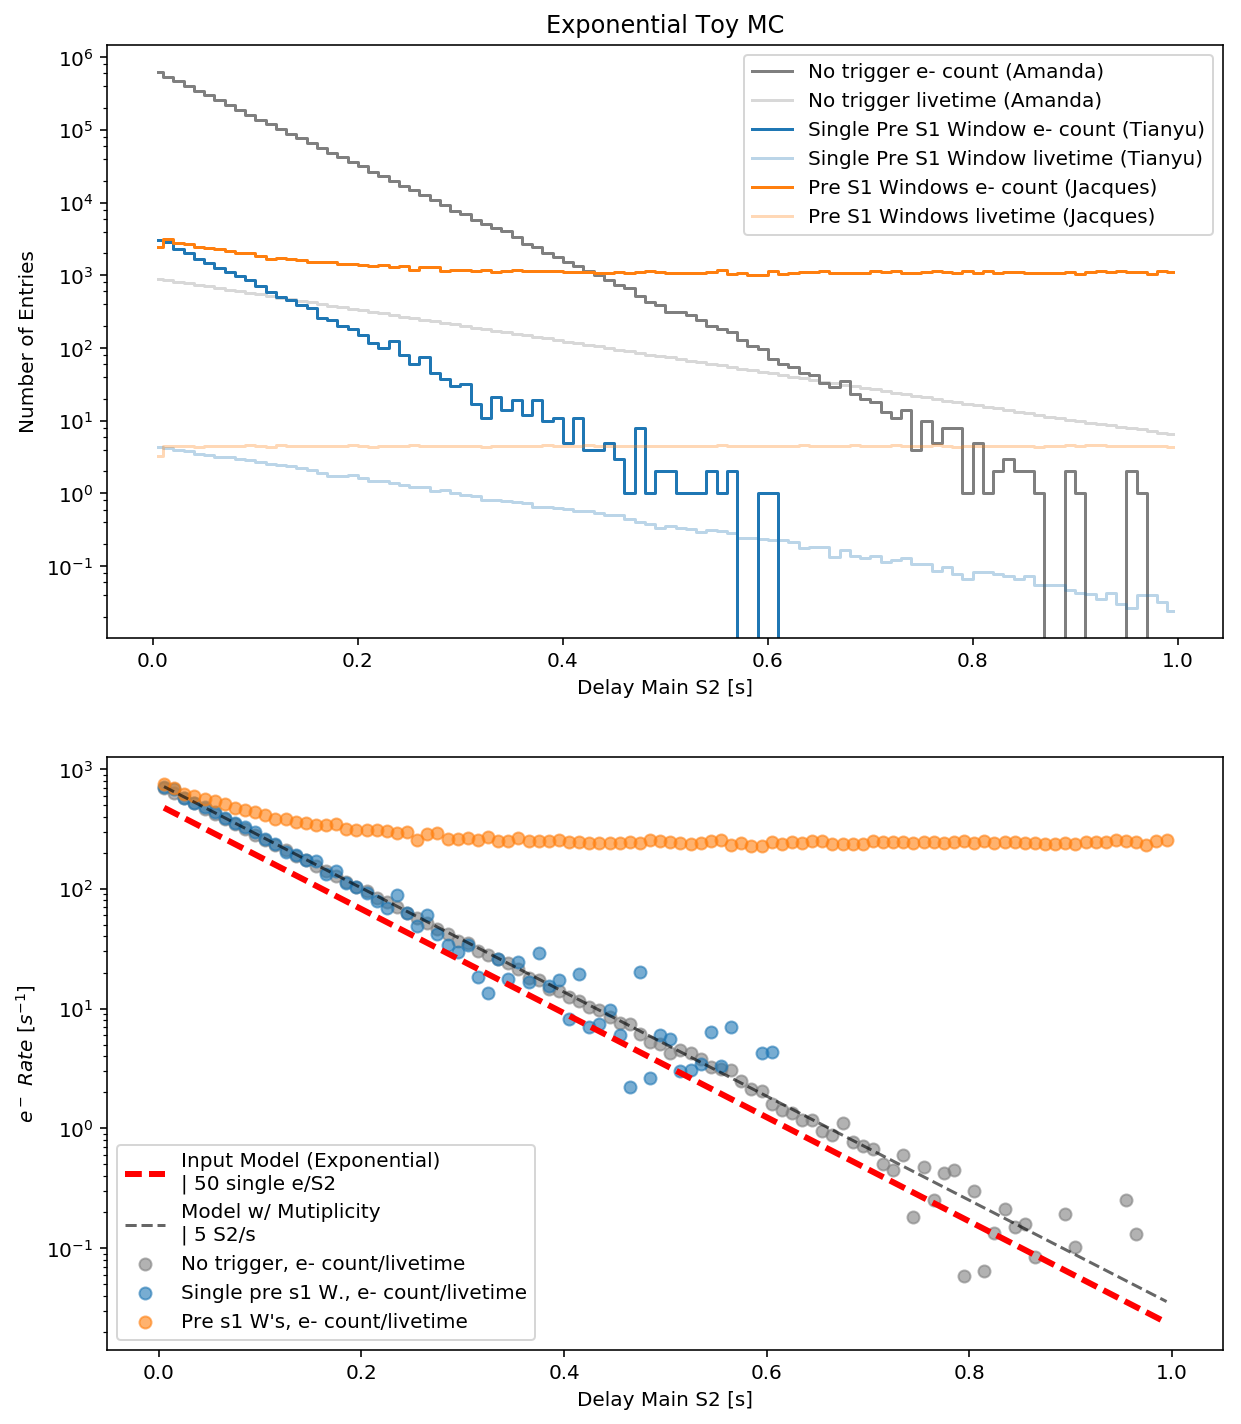

In [8]:
with initiate_plot(10, 12):
    ax = fig.add_subplot(211)
    ph_dt_0.plot(color='C7', label='No trigger e- count (Amanda)')
    ph_lt_0.plot(color='C7', alpha = 0.3, label='No trigger livetime (Amanda)')
    
    ph_dt_1.plot(color='C0', label='Single Pre S1 Window e- count (Tianyu)')
    ph_lt_1.plot(color='C0', alpha = 0.3, label='Single Pre S1 Window livetime (Tianyu)')
    
    ph_dt_2.plot(color='C1', label='Pre S1 Windows e- count (Jacques)')
    ph_lt_2.plot(color='C1', alpha = 0.3, label='Pre S1 Windows livetime (Jacques)')
    
    plt_config(xlabel='Delay Main S2 [s]', ylabel='Number of Entries', title='Exponential Toy MC')
    plt.yscale('log')
    plt.legend()
    
    ax = fig.add_subplot(212)
    plt.scatter(ph_dt_0.bin_centers, ph_dt_0/ph_lt_0, color='C7', alpha=0.6, label ='No trigger, e- count/livetime')
    plt.scatter(ph_dt_0.bin_centers, ph_dt_1/ph_lt_1, color='C0', alpha=0.6, label ='Single pre s1 W., e- count/livetime')
    plt.scatter(ph_dt_0.bin_centers, ph_dt_2/ph_lt_2, color='C1', alpha=0.6, label ='Pre s1 W\'s, e- count/livetime')


        
    bc = ph_dt_0.bin_centers
    bin_width = np.diff(bins, n=1)
    # Model = ratio * normalized exponential pdf (t)
    #       * bin width
    plt.plot(bc, ratio/tao*np.exp(-bc/tao), color='r', alpha=1, lw=3.0, ls='--', label='Input Model (Exponential)\n| 50 single e/S2')
    # Model with multiplicity = ratio * normalized exponential pdf
    #                    + intergal of t_s2 ratio * normalized exponential pdf (t-t_s2) 
    #                        * s2_distribution (uniform 5/second)
    #                        from -inf to 0
    #                    * bin width
    plt.plot(bc, ratio/tao*np.exp(-bc/tao)*(1+5*tao), color='k', alpha=0.6, ls='--', label='Model w/ Mutiplicity\n| 5 S2/s')
    
    plt_config(xlabel='Delay Main S2 [s]', ylabel='$e^-\ Rate\ [s^{-1}]$')
    plt.yscale('log')
    plt.legend()

In [9]:
bins = np.linspace(0, 1, 101);
total_time = 1000; # simulated time span
tao0, tao1 = 0.01, 1; # electron train decay constant
p0, p1 = 0.9, 1-0.9; # normalization between two decay constant
ratio = 50; # number of model electron train per s2
histograms = np.zeros((6, len(bins)-1))


def double_exponential_model_random_gen(n):
    taos = np.random.choice([tao0, tao1], n, replace=True, p=[p0, p1])
    return -np.log(1-np.random.uniform(0, 1, n))*taos

n_loop = 18 # 18*1000s ~ 5hr, need to break it down to 18 piecec due to RAM requirement
with tqdm(total = n_loop) as pBar:
    for ix in range(n_loop):
        pBar.update(1)
        histograms += simulations(double_exponential_model_random_gen, total_time, tao, ratio)
        
ph_dt_0 = Hist1d.from_histogram(histograms[0], bin_edges = bins)
ph_lt_0 = Hist1d.from_histogram(histograms[1], bin_edges = bins)
ph_dt_1 = Hist1d.from_histogram(histograms[2], bin_edges = bins)
ph_lt_1 = Hist1d.from_histogram(histograms[3], bin_edges = bins)
ph_dt_2 = Hist1d.from_histogram(histograms[4], bin_edges = bins)
ph_lt_2 = Hist1d.from_histogram(histograms[5], bin_edges = bins)

100%|██████████| 18/18 [00:22<00:00,  1.32s/it]


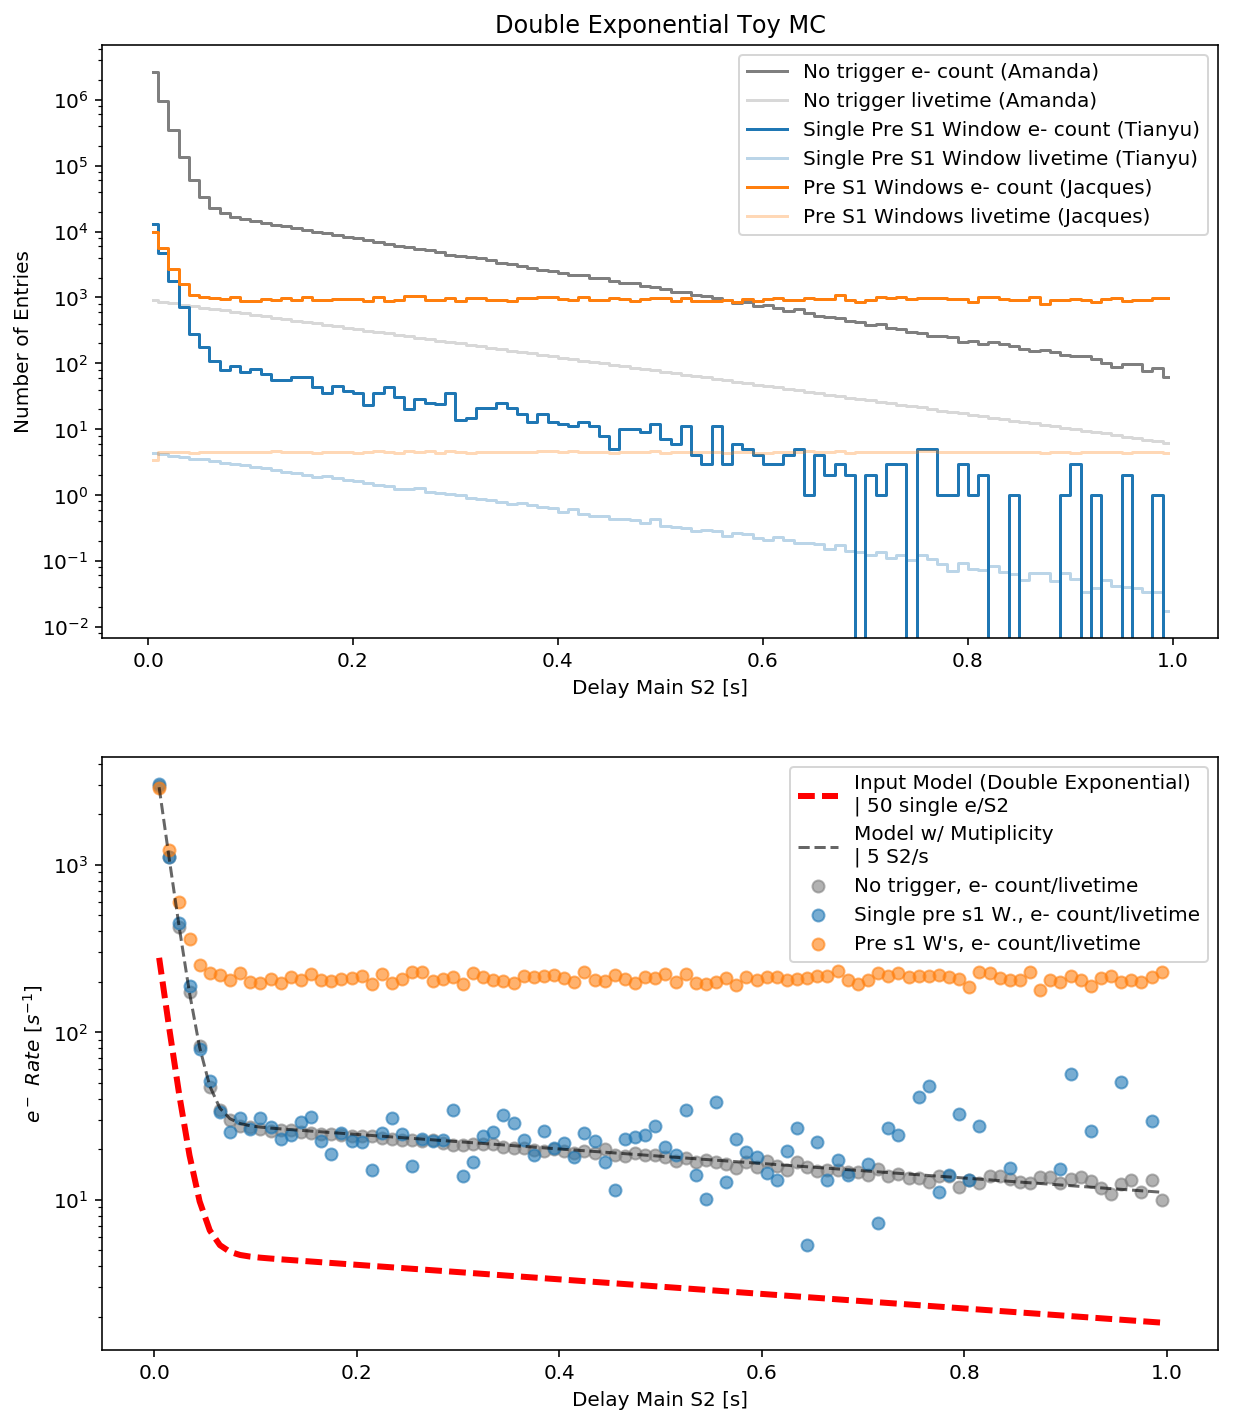

In [10]:
with initiate_plot(10, 12):
    ax = fig.add_subplot(211)
    ph_dt_0.plot(color='C7', label='No trigger e- count (Amanda)')
    ph_lt_0.plot(color='C7', alpha = 0.3, label='No trigger livetime (Amanda)')
    
    ph_dt_1.plot(color='C0', label='Single Pre S1 Window e- count (Tianyu)')
    ph_lt_1.plot(color='C0', alpha = 0.3, label='Single Pre S1 Window livetime (Tianyu)')
    
    ph_dt_2.plot(color='C1', label='Pre S1 Windows e- count (Jacques)')
    ph_lt_2.plot(color='C1', alpha = 0.3, label='Pre S1 Windows livetime (Jacques)')
    
    plt_config(xlabel='Delay Main S2 [s]', ylabel='Number of Entries', title='Double Exponential Toy MC')
    plt.yscale('log')
    plt.legend()
    
    ax = fig.add_subplot(212)
    plt.scatter(ph_dt_0.bin_centers, ph_dt_0/ph_lt_0, color='C7', alpha=0.6, label ='No trigger, e- count/livetime')
    plt.scatter(ph_dt_0.bin_centers, ph_dt_1/ph_lt_1, color='C0', alpha=0.6, label ='Single pre s1 W., e- count/livetime')
    plt.scatter(ph_dt_0.bin_centers, ph_dt_2/ph_lt_2, color='C1', alpha=0.6, label ='Pre s1 W\'s, e- count/livetime')


        
    bc = ph_dt_0.bin_centers
    bin_width = np.diff(bins, n=1)
    # Model = ratio * normalized exponential pdf (t)
    #       * bin width
    plt.plot(bc, (p0*ratio/tao*np.exp(-bc/tao0)+p1*ratio/tao1*np.exp(-bc/tao1)),
             color='r', alpha=1, lw=3.0, ls='--', label='Input Model (Double Exponential)\n| 50 single e/S2')
    # Model with multiplicity = ratio * normalized exponential pdf
    #                    + intergal of t_s2 ratio * normalized exponential pdf (t-t_s2) 
    #                        * s2_distribution (uniform 5/second)
    #                        from -inf to 0
    #                    * bin width
    plt.plot(bc, (p0*ratio/tao0*np.exp(-bc/tao0)*(1+5*tao0)+p1*ratio/tao1*np.exp(-bc/tao1)*(1+5*tao1)),
             color='k', alpha=0.6, ls='--', label='Model w/ Mutiplicity\n| 5 S2/s')
    
    plt_config(xlabel='Delay Main S2 [s]', ylabel='$e^-\ Rate\ [s^{-1}]$')
    plt.yscale('log')
    plt.legend()